# "Nadaraya-Watson 커널 회귀"
> "Dive into deep learning의 Nadaraya-Watson 커널 회귀 재구현"

- toc: true
- badges: true
- author: 단호진
- categories: [nlp]

## 어텐션

d2l에서 Nadaraya-Watson 커널 회귀 방법을 사용하여 어텐션 개념을 소개하고 있다[1]. 어텐션을 일종의 회귀로 볼 수 있다는 점은 중요하다. 우리가 알고 있거나 이미 처리해 둔 입력과 출력으로 만들어진 함수가 존재할 때 새로운 입력에 대한 회귀 적합을 생각해 볼 수 있다. 선형 회귀 형식을 빌어보면 기울기 추정량은 다음과 같고,

$\hat \beta = (X'X)^{-1} (X'Y)$

새로운 입력 $X_{\text{test}}$에 대하여 y를 추정하게 된다.

$\hat y = X_{\text{test}} \hat \beta = X_{\text{test}} (X'X)^{-1} (X'Y)$

위 식에는 훈련 데이터에서 특징 변수 내, 그리고 특징 변수와 응답 변수 사이의 관계가 들어 있다. 결국 새로운 입력은 훈련에 사용된 입력 및 응답을 참고하여 응답을 예측하게 된다. 일반적인 형식으로 표현하면 다음과 같고, 이를 어텐션 풀링(attention pooling)이라고 한다.

$f(x) = \sum_{i=1}^{n} \alpha(x, x_i) y_i $

$\alpha$는 어텐션 계수가 되어 기지의 응답에 대한 가중치로 볼 수 있다. 이와 같이 어텐션의 개념은 간단하나 응용을 위하여, 가령 Seq2Seq 모델에 삽입해 RNN의 단점을 보완하는 어텐션 기능을 넣어야 하는 것은 또 다른 문제이므로 기존 연구자들의 성공적인 구성을 많이 참고해야 하겠다. 


일견 간단한 Nadaraya-Watson 커널 회귀 문제에 대한 d2l 코드를 처음 보았을 때 당혹감이 일었다. 수식은 간단하나 pytorch 프레임 내에서 어떻게 구현해야 하는지 머리에 떠오르지 않았기 때문이다. 이 포스트는 d2l 코드를 참고하면서 스스로 이해할 수 있도록 코드를 재구성의 결과이다. 다음 사항에 대하여 정리하는 계기가 되었다.

* 학습 파라미터의 직접 정의
* torch.repeat 함수 및 텐서 연산에서 브로드캐스팅(broadcasting)

참고

1. Aston Zhang, et al., Dive into Deep Learning, https://d2l.ai/chapter_attention-mechanisms/nadaraya-waston.html
2. 유원준, 딥 러닝을 이용한 자연어 처리 입문, https://wikidocs.net/22893

In [1]:
# !pip install d2l
# !pip install torch==1.7.1+cpu torchvision==0.8.2+cpu torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

## 인공 데이터 및 유틸함수 정의

d2l 코드를 그대로 재사용 하였다.

In [2]:
from d2l import torch as d2l
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import seaborn as sns


n_train = 50  # No. of training examples
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # Training inputs

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # Training outputs
x_test = torch.arange(0, 5, 0.2)  # Testing examples
y_truth = f(x_test)  # Ground-truth outputs for the testing examples
print(f'shape of train x/y: {x_train.shape}/{y_train.shape}')
print(f'shape of test x: {x_test.shape}')

def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

shape of train x/y: torch.Size([50])/torch.Size([50])
shape of test x: torch.Size([25])


## 어텐션 풀링 모델

이미 알고 있는 데이터라는 점을 강조하기 위하여 keys/values 짝을 파라미터에 정의하였다. 이 데이터는 모델 생성시 넣어 주어야 한다. 학습 가능한 파라미터는 자유도 1인 weight 하나이다.

In [3]:
class NWKernelRegression(nn.Module):
    def __init__(self, keys, values):
        super().__init__()
        self.keys = nn.Parameter(keys, requires_grad=False)
        self.values = nn.Parameter(values, requires_grad=False)
        self.weight = nn.Parameter(torch.rand(1), requires_grad=True)

    @property
    def attention_weights(self):
        return self._attention_weights.detach()
        
    def forward(self, queries: torch.Tensor):
        N = queries.size(0)  # Batch size
        self._attention_weights = queries - self.keys.repeat((N, 1))
        self._attention_weights = F.softmax(
            torch.pow(self._attention_weights * self.weight, 2.0) / (-2.0), dim=-1)
        return (self._attention_weights * self.values.repeat((N, 1))).sum(dim=-1)  # kind of torch.bmm

## 학습

과적합 문제는 발생하지 않았다. 가우스 커널을 준용한데 따른 결과일 것이다.

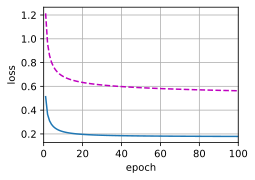

In [4]:
torch.manual_seed(952)

epochs, lr = 100, 0.5

mod_1 = NWKernelRegression(x_train, y_train)
loss = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(mod_1.parameters(), lr=lr)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[0, epochs])

mask = torch.randint(n_train, size=(int(n_train * 0.2),))

for epoch in range(1, epochs + 1):
    mod_1.train()
    pred = mod_1(x_train.view((-1, 1)))
    l = loss(pred[~mask], y_train[~mask])
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    mod_1.eval()
    l_eval = loss(pred[mask], y_train[mask])
    animator.add(epoch, [l.item(), l_eval.item()])

## 평가

학습 결과 weight=2.58을 얻었다. 히트맵에 때르면 검정 데이터 주변의 훈련 데이터를 참고하여 어텐션 가중치를 구하여 응답을 구성하는 것을 알 수 있다.

In [5]:
list([p for p in mod_1.parameters() if p.requires_grad])

[Parameter containing:
 tensor([2.9848], requires_grad=True)]

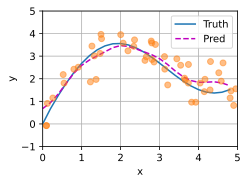

In [6]:
mod_1.eval()
y_hat = mod_1(x_test.view((-1, 1)))
plot_kernel_reg(y_hat.detach())

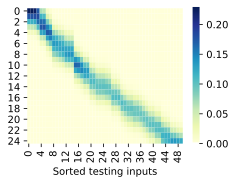

In [7]:
import seaborn as sns

ax = sns.heatmap(mod_1.attention_weights.numpy(), cmap='YlGnBu')
ax.set_xlabel('Sorted training inputs')
ax.set_xlabel('Sorted testing inputs');